# Top overlapping annotations by weighted sum for saur cohort

In [1]:
import pandas as pd


pd.set_option("display.max_columns", None) # show all cols
pd.set_option('display.max_colwidth', None) # show full width of showing cols
pd.set_option("display.expand_frame_repr", False) # print cols side by side as it's supposed to be

## Read token information from bed files

In [2]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'ECOLI')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,1,3,GAA,0.024555,AH21B049
1,1,4,12,AAACCCCGG,0.019281,AH21B049
2,1,13,17,TCAAT,0.042749,AH21B049
3,1,18,22,AAGGC,0.058446,AH21B049
4,1,23,27,CGGGG,-0.002272,AH21B049
...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077
247349729,5,259939,259942,GGCC,0.024973,ALF22C077


<Axes: >

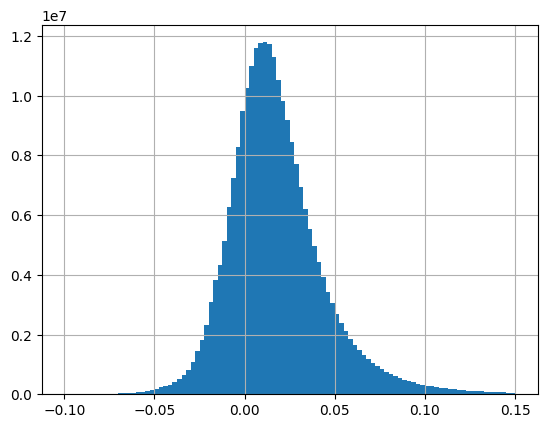

In [7]:
bedDf[(bedDf.score > -0.1) & (bedDf.score < 0.15)].score.hist(bins=100)

In [8]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,1,3,GAA,0.024555,AH21B049,3
1,1,4,12,AAACCCCGG,0.019281,AH21B049,9
2,1,13,17,TCAAT,0.042749,AH21B049,5
3,1,18,22,AAGGC,0.058446,AH21B049,5
4,1,23,27,CGGGG,-0.002272,AH21B049,5
...,...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077,8
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077,8
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077,10
247349729,5,259939,259942,GGCC,0.024973,ALF22C077,4


In [9]:
len(bedDf.tokens.unique())

31990

In [10]:
highscoreCutoff = bedDf.score.mean() + 3 * bedDf.score.std()
highscoreCutoff

np.float64(0.10044996853550375)

In [11]:
highscoreDf = bedDf[bedDf.score > highscoreCutoff]
highscoreDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
790,1,5456,5461,TTCCGG,0.109817,AH21B049,6
1113,1,7709,7713,CCGAC,0.111683,AH21B049,5
1141,1,7901,7906,GGTTTT,0.126671,AH21B049,6
1147,1,7939,7943,GACAG,0.138056,AH21B049,5
1544,1,10694,10701,CCCGACGG,0.119595,AH21B049,8
...,...,...,...,...,...,...,...
247348343,5,250450,250457,CCCTTTTT,0.104689,ALF22C077,8
247348387,5,250737,250741,ACAGA,0.114884,ALF22C077,5
247349058,5,255352,255357,GAAAAA,0.100641,ALF22C077,6
247349081,5,255503,255508,ACGCTG,0.112193,ALF22C077,6


In [12]:
len(highscoreDf.tokens.unique())

13592

In [13]:
highscoreDf.shape

(3266793, 7)

<Axes: >

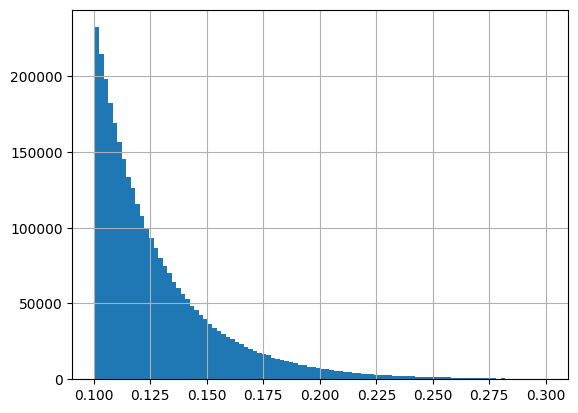

In [15]:
highscoreDf[(highscoreDf.score < 0.3)].score.hist(bins=100)

In [16]:
highscoreDf.token_length.value_counts()

token_length
6     1005832
7      585361
5      449264
8      339503
9      263575
4      262709
3      186469
10      92597
2       40984
11      30865
1        4650
12       2730
16       1991
15        152
13        102
14          9
Name: count, dtype: int64

<Axes: xlabel='token_length', ylabel='Count'>

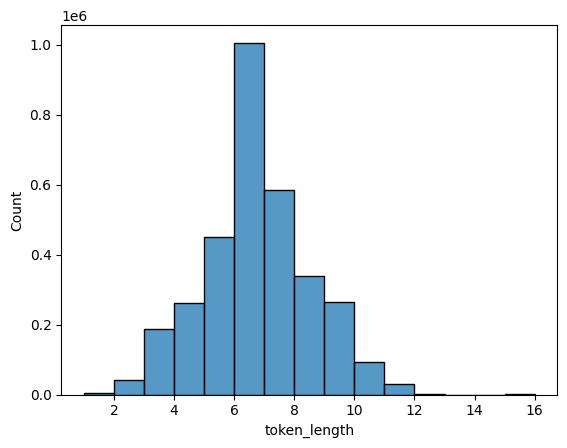

In [17]:
import seaborn as sns

sns.histplot(highscoreDf.token_length, binwidth=1)

## Read core genes

In [18]:
import os
from pathlib import Path

import pandas as pd


coreGenesPath = Path(os.environ['GENOMICS_DATA_BASE'], 'annotations', 'e_coli_panaroo_strict', 'core_genes.csv')
coreGenesDf = pd.read_csv(coreGenesPath)
coreGenesDf['Gene'] = coreGenesDf.Gene.str.lower()
coreGenesDf

,Gene,Occurrences
0,zrar,861
1,group_9359,861
2,bira,861
3,group_9358,861
4,this~~~thif,861
...,...,...
2301,ycii,861
2302,emta,861
2303,rpsc,861
2304,fre,861


## Read bed files containing overlapping tokens and attribution scores

In [19]:
from tqdm import tqdm

import os
import pandas as pd
from pathlib import Path


annotationOverlappingFilesDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'overlapping_with_annotations', 'ECOLI')

annotationOverlappingDfList = []
for annotationOverlappingFile in tqdm(os.listdir(annotationOverlappingFilesDir)):
    df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
    df = df[df.feature_type.isin(['CDS', 'ncRNA', 'oriC', 'regulatory_region', 'oriT'])]
    df['tube_code'] = [annotationOverlappingFile.split('_')[0]]*df.shape[0]
    df = df[df.tokens.apply(lambda x: (len(x) >= 5))].reset_index()
    df['gene'] = df.gene.str.lower()
    coreDf = df[df.gene.isin(coreGenesDf.Gene)]
    annotationOverlappingDfList.append(coreDf)
annotationOverlappingDf = pd.concat(annotationOverlappingDfList, ignore_index=True)
annotationOverlappingDf = annotationOverlappingDf.drop_duplicates()
annotationOverlappingDf

  0%|          | 0/358 [00:00<?, ?it/s]

100%|██████████| 358/358 [08:29<00:00,  1.42s/it]


,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code
0,98,1,1943,1948,TAATTT,0.010497,CDS,IGMLFD_00010,taurine ABC transporter substrate-binding protein,taua,"ID=IGMLFD_00010;Name=taurine ABC transporter substrate-binding protein;locus_tag=IGMLFD_00010;product=taurine ABC transporter substrate-binding protein;Dbxref=COG:COG4521,COG:P,GO:0006790,GO:0009970,GO:0010438,GO:0015734,GO:0022857,GO:0030288,GO:0042918,GO:0042959,GO:0055052,RefSeq:WP_001350622.1,SO:0001217,UniParc:UPI0001610B7D,UniRef:UniRef100_A0A2J1BVM4,UniRef:UniRef50_Q47537,UniRef:UniRef90_Q47537;gene=tauA",AH19C036
1,99,1,1949,1954,CATCGC,0.024850,CDS,IGMLFD_00010,taurine ABC transporter substrate-binding protein,taua,"ID=IGMLFD_00010;Name=taurine ABC transporter substrate-binding protein;locus_tag=IGMLFD_00010;product=taurine ABC transporter substrate-binding protein;Dbxref=COG:COG4521,COG:P,GO:0006790,GO:0009970,GO:0010438,GO:0015734,GO:0022857,GO:0030288,GO:0042918,GO:0042959,GO:0055052,RefSeq:WP_001350622.1,SO:0001217,UniParc:UPI0001610B7D,UniRef:UniRef100_A0A2J1BVM4,UniRef:UniRef50_Q47537,UniRef:UniRef90_Q47537;gene=tauA",AH19C036
2,101,1,1958,1966,ACACATTTC,0.000009,CDS,IGMLFD_00010,taurine ABC transporter substrate-binding protein,taua,"ID=IGMLFD_00010;Name=taurine ABC transporter substrate-binding protein;locus_tag=IGMLFD_00010;product=taurine ABC transporter substrate-binding protein;Dbxref=COG:COG4521,COG:P,GO:0006790,GO:0009970,GO:0010438,GO:0015734,GO:0022857,GO:0030288,GO:0042918,GO:0042959,GO:0055052,RefSeq:WP_001350622.1,SO:0001217,UniParc:UPI0001610B7D,UniRef:UniRef100_A0A2J1BVM4,UniRef:UniRef50_Q47537,UniRef:UniRef90_Q47537;gene=tauA",AH19C036
3,102,1,1967,1977,TTGCCGCACTG,0.013496,CDS,IGMLFD_00010,taurine ABC transporter substrate-binding protein,taua,"ID=IGMLFD_00010;Name=taurine ABC transporter substrate-binding protein;locus_tag=IGMLFD_00010;product=taurine ABC transporter substrate-binding protein;Dbxref=COG:COG4521,COG:P,GO:0006790,GO:0009970,GO:0010438,GO:0015734,GO:0022857,GO:0030288,GO:0042918,GO:0042959,GO:0055052,RefSeq:WP_001350622.1,SO:0001217,UniParc:UPI0001610B7D,UniRef:UniRef100_A0A2J1BVM4,UniRef:UniRef50_Q47537,UniRef:UniRef90_Q47537;gene=tauA",AH19C036
4,103,1,1978,1982,GCATT,0.034052,CDS,IGMLFD_00010,taurine ABC transporter substrate-binding protein,taua,"ID=IGMLFD_00010;Name=taurine ABC transporter substrate-binding protein;locus_tag=IGMLFD_00010;product=taurine ABC transporter substrate-binding protein;Dbxref=COG:COG4521,COG:P,GO:0006790,GO:0009970,GO:0010438,GO:0015734,GO:0022857,GO:0030288,GO:0042918,GO:0042959,GO:0055052,RefSeq:WP_001350622.1,SO:0001217,UniParc:UPI0001610B7D,UniRef:UniRef100_A0A2J1BVM4,UniRef:UniRef50_Q47537,UniRef:UniRef90_Q47537;gene=tauA",AH19C036
...,...,...,...,...,...,...,...,...,...,...,...,...
39275166,298470,5,329381,329386,TGGCGT,0.013887,CDS,KCGHAI_11620,DNA replication protein DnaC,dnac,"ID=KCGHAI_11620;Name=DNA replication protein DnaC;locus_tag=KCGHAI_11620;product=DNA replication protein DnaC;Dbxref=COG:COG1484,COG:L,KEGG:K10762,RefSeq:WP_000788950.1,SO:0001217,UniParc:UPI00005F134E,UniRef:UniRef100_A0A061YIZ0,UniRef:UniRef50_A0A061YIZ0,UniRef:UniRef90_A0A061YIZ0;gene=dnaC",AH19F069
39275167,298471,5,329387,329393,CCAAATG,0.017108,CDS,KCGHAI_11620,DNA replication protein DnaC,dnac,"ID=KCGHAI_11620;Name=DNA replication protein DnaC;locus_tag=KCGHAI_11620;product=DNA replication protein DnaC;Dbxref=COG:COG1484,COG:L,KEGG:K10762,RefSeq:WP_000788950.1,SO:0001217,UniParc:UPI00005F134E,UniRef:UniRef100_A0A061YIZ0,UniRef:UniRef50_A0A061YIZ0,UniRef:UniRef90_A0A061YIZ0;gene=dnaC",AH19F069
39275168,298472,5,329394,329401,TCAGCAAT,0.018828,CDS,KCGHAI_11620,DNA replication protein DnaC,dnac,"ID=KCGHAI_11620;Name=DNA replication protein DnaC;locus_tag=KCGHAI_11620;product=DNA replication protein DnaC;Dbxref=COG:COG1484,COG:L,KEGG:K10762,RefSeq:WP_000788950.1,SO:0001217,UniParc:UPI00005F134E,UniRef:UniRef100_A0A061YIZ0,UniRef:UniRef50_A0A061YIZ0,UniRef:UniR

In [20]:
from tqdm import tqdm


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrOverlappingDfList = []
for tubeId in tqdm(bedDf.tube_id.unique()):
    tubeidHighscoreDf = highscoreDf[highscoreDf.tube_id == tubeId]
    amrfinderFile = Path(amrfinderDir, tubeId + '_amr_results.txt')
    if(amrfinderFile.exists()):
        amrfinderDf = pd.read_csv(amrfinderFile, sep='\t')
        mergedDf = tubeidHighscoreDf.merge(
            amrfinderDf,
            how='inner',
            left_on = ['contig_id'],
            right_on = ['Contig id'],
        )
        mergedDf['tube_code'] = tubeId
        tubeidOverlappingDf = mergedDf[(mergedDf.start_position >= mergedDf.Start) & (mergedDf.end_position <= mergedDf.Stop)]
        amrOverlappingDfList.append(tubeidOverlappingDf)

amrOverlappingDf = pd.concat(amrOverlappingDfList, ignore_index=True)
amrOverlappingDf

100%|██████████| 861/861 [02:09<00:00,  6.67it/s]


,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
0,1,395434,395439,GAACGT,0.107013,AH21B049,6,NaN,1,394617,395984,+,ibeA,putative intracellular survival FAD-dependent oxidoreductase IbeA,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,456,456,100.0,97.81,456,AAF98391.2,putative intracellular survival FAD-dependent oxidoreductase IbeA,NaN,NaN,AH21B049
1,4,10223,10231,TTTCACATC,0.125651,AH21B049,9,NaN,4,5811,10370,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1520,1520,100.0,92.43,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH21B049
2,4,10271,10276,GGAGGA,0.156269,AH21B049,6,NaN,4,5811,10370,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1520,1520,100.0,92.43,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH21B049
3,4,10299,10304,CAACCG,0.104414,AH21B049,6,NaN,4,5811,10370,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1520,1520,100.0,92.43,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH21B049
4,4,322635,322639,ACCGA,0.120406,AH21B049,5,NaN,4,322345,325446,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH21B049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14814,5,348217,348226,CTGGGCTGGG,0.121704,AH19C036,10,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036
14815,5,348237,348242,CTGACC,0.110060,AH19C036,6,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036
14816,5,348254,348260,CCAGTTG,0.100546,AH19C036,7,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036
14817,5,348533,348535,CGC,0.107089,AH19C036,3,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036


In [21]:
overlappingDf = pd.concat(
    [
        annotationOverlappingDf[['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'gene', 'name', 'tube_code']],
        amrOverlappingDf[['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'Gene symbol', 'Sequence name', 'tube_code']].rename(columns={'Gene symbol': 'gene', 'Sequence name': 'name'})
    ],
    names=['contig_id', 'start_position', 'end_position', 'tokens', 'gene'],
    ignore_index=False
)
overlappingDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,1943,1948,TAATTT,0.010497,taua,taurine ABC transporter substrate-binding protein,AH19C036
1,1,1949,1954,CATCGC,0.024850,taua,taurine ABC transporter substrate-binding protein,AH19C036
2,1,1958,1966,ACACATTTC,0.000009,taua,taurine ABC transporter substrate-binding protein,AH19C036
3,1,1967,1977,TTGCCGCACTG,0.013496,taua,taurine ABC transporter substrate-binding protein,AH19C036
4,1,1978,1982,GCATT,0.034052,taua,taurine ABC transporter substrate-binding protein,AH19C036
...,...,...,...,...,...,...,...,...
14814,5,348217,348226,CTGGGCTGGG,0.121704,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
14815,5,348237,348242,CTGACC,0.110060,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
14816,5,348254,348260,CCAGTTG,0.100546,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
14817,5,348533,348535,CGC,0.107089,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036


## Get overlapping genes for high-score tokens

In [22]:
highscoreTokenOverlapsDf = overlappingDf.merge(
    highscoreDf[['contig_id', 'start_position', 'end_position', 'tokens']],
    on=['contig_id', 'start_position', 'end_position', 'tokens'],
    how='inner',
)
highscoreTokenOverlapsDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,3240,3248,ACACCAGAT,0.111607,taub,taurine ABC transporter ATP-binding subunit,AH19C036
1,1,3240,3248,ACACCAGAT,0.111607,taub,taurine ABC transporter ATP-binding subunit,AH19C036
2,1,3240,3248,ACACCAGAT,0.111607,taub,taurine ABC transporter ATP-binding subunit,AH19C036
3,1,3240,3248,ACACCAGAT,0.111607,taub,taurine ABC transporter ATP-binding subunit,AH19C036
4,1,3240,3248,ACACCAGAT,0.111607,taub,taurine ABC transporter ATP-binding subunit,AH19C036
...,...,...,...,...,...,...,...,...
1072899,5,348217,348226,CTGGGCTGGG,0.121704,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
1072900,5,348237,348242,CTGACC,0.110060,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
1072901,5,348254,348260,CCAGTTG,0.100546,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
1072902,5,348533,348535,CGC,0.107089,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036


## Calculate weighted sum for all the genes overlapping with high-score tokens

In [23]:
import numpy as np


geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
geneWeightedsumDf

/tmp/ipykernel_112799/2423154480.py:4: FutureWarning: The provided callable <function sum at 0x75c855b803a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,gene,weighted_sum
0,aac(3)-IId,0.842917
1,aadA1,1.352251
2,aaea,96.664124
3,aaeb,203.875719
4,aaer,28.625057
...,...,...
1832,znuc,118.372942
1833,zras,0.105720
1834,zupt,53.861828
1835,zur,2.640610


## Visualise weighted sum

<Axes: xlabel='weighted_sum', ylabel='Count'>

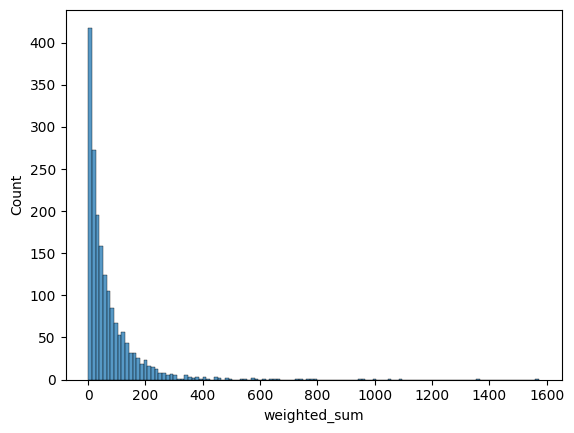

In [24]:
import seaborn as sns


sns.histplot(geneWeightedsumDf.weighted_sum)

## Top genes based on the weighted sum

In [25]:
weightedsumCutoff = geneWeightedsumDf.weighted_sum.mean() + (2 * geneWeightedsumDf.weighted_sum.std())
weightedsumCutoff

np.float64(301.8543757317028)

In [26]:
geneWeightedsumDf[geneWeightedsumDf.weighted_sum > weightedsumCutoff].sort_values(by=['weighted_sum'], ascending=False)

,gene,weighted_sum
24,acrF,1573.600212
10,accc,1356.848448
415,ftsh,1094.733786
557,hsca,1052.384850
1696,yhdx,1004.086351
854,nank,955.143446
278,der,947.119105
1694,yhdp,788.729482
472,gltb,786.274712
656,lepb,762.158826


## Create gene-type lookup table from amrfinderplus annotations

In [27]:
import os

import pandas as pd

from pathlib import Path


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrfinderDfList = []
for amrfinderFile in os.listdir(amrfinderDir):
    amrfinderDf = pd.read_csv(Path(amrfinderDir, amrfinderFile), sep='\t')
    amrfinderDfList.append(amrfinderDf)

allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)
allAmrfinderDf

/tmp/ipykernel_112799/536070399.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)


,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description
0,NaN,1,83926,85452,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.00,99.41,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN
1,NaN,1,128415,129464,+,icaC,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,350,350,100.00,100.00,350,AUU58561.1,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,NaN,NaN
2,NaN,1,150950,154498,-,cna,collagen adhesin Cna,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1183,1183,100.00,98.31,1183,BAB96477.1,collagen adhesin Cna,NaN,NaN
3,NaN,1,277464,278813,+,tet(38),tetracycline efflux MFS transporter Tet(38),core,AMR,AMR,TETRACYCLINE,TETRACYCLINE,EXACTX,450,450,100.00,100.00,450,WP_001100300.1,tetracycline efflux MFS transporter Tet(38),NaN,NaN
4,NaN,1,505300,506652,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.00,99.33,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57610,NaN,17,83399,84580,-,emrD,multidrug efflux MFS transporter EmrD,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,394,394,100.00,99.24,394,ACN65732.1,multidrug efflux MFS transporter EmrD,NaN,NaN
57611,NaN,2,213498,214724,-,kdeA,multidrug efflux MFS transporter KdeA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,409,410,99.76,99.02,409,ABR76310.1,multidrug efflux MFS transporter KdeA,NaN,NaN
57612,NaN,3,59710,60882,+,oqxA,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,BLASTX,391,391,100.00,99.23,391,WP_002914189.1,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,NaN,NaN
57613,NaN,3,60909,64058,+,oqxB9,multidrug efflux RND transporter permease subunit OqxB9,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,ALLELEX,1050,1050,100.00,100.00,1050,WP_012967412.1,multidrug efflux RND transporter permease subunit OqxB9,NaN,NaN


In [28]:
genetypeLookupDf = allAmrfinderDf[['Gene symbol', 'Element type']].drop_duplicates()
genetypeLookupDf['Gene symbol'] = genetypeLookupDf['Gene symbol'].str.lower()
genetypeLookupDf

,Gene symbol,Element type
0,aur,VIRULENCE
1,icac,VIRULENCE
2,cna,VIRULENCE
3,tet(38),AMR
4,mepa,AMR
...,...,...
55837,blapdc-58,AMR
56358,blaact-49,AMR
56951,blandm-4,AMR
56963,aac(6')-ib-cr,AMR


## Read vfdb info

In [29]:
import os
import pandas as pd
from pathlib import Path


vfdbInfoFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'VFDB_info.csv')
vfdbInfoDf = pd.read_csv(vfdbInfoFile)
vfdbInfoDf['Label'] = vfdbInfoDf['Label'].str.lower()
vfdbInfoDf

,Column,ID,Label,Description,Source,Class
0,1,c0393,vat,hemoglobin protease,Escherichia coli O6:K2:H1 CFT073 (UPEC),Autotransporters
1,2,APECO1_O1CoBM73,tsh,Tsh,Escherichia coli O1:K1:H7 (APEC),Autotransporters
2,3,Q673F0_ECOLX,rpea,putative SPATE autotransporter; similar to the SPATE proteins,Escherichia coli plasmid pRAP strain REPEC 83/39,Autotransporters
3,4,ECSF_4010,ecsf_4010,phage protein,Escherichia coli SE15,Autotransporters
4,5,EcSMS35_3921,ecsms35_3921,outer membrane autotransporter,Escherichia coli SMS-3-5 (environmental),Autotransporters
...,...,...,...,...,...,...
249,250,c5077,yddo,ABC transporter ATP-binding protein,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
250,251,c5078,c5078,oligopeptide ABC transporter,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
251,252,c5079,yddq,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
252,253,c5080,yddr,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes


## Read vf collection

In [30]:
import os
import pandas as pd
from pathlib import Path


vfCollectionDescriptionFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ecoli_VF_collection_description.tsv')
vfCollectionDescriptionDf = pd.read_csv(vfCollectionDescriptionFile, sep='\t')
vfCollectionDescriptionDf['gene'] = vfCollectionDescriptionDf['gene'].str.lower()
vfCollectionDescriptionDf

,gene,locus tag,accession number (protein_id),description,reference,source,class
0,aap,EC042_pAA055,NaN,dispersin,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
1,aata,EC042_pAA008,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
2,aatb,EC042_pAA009,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
3,aatc,EC042_pAA010,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
4,aatd,EC042_pAA011,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
...,...,...,...,...,...,...,...
1064,lngj,NaN,ABU50049,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1065,lngp,NaN,ABU50050,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1066,etsa,APECO1_O1CoBM197,YP_001481352,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene
1067,etsb,APECO1_O1CoBM198,YP_001481353,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene


## Read ABRicate

In [31]:
import os
import pandas as pd
from pathlib import Path


abricateFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ABRicate.csv')
abricateDf = pd.read_csv(abricateFile)
abricateDf['gene'] = abricateDf['gene'].str.lower()
abricateDf

,gene,type
0,aaa23990,heat-stable enterotoxin
1,aaa24093,heat labile enterotoxin type IIa A
2,aaa24094,heat labile enterotoxin type IIa B
3,apeco1_1753,hypothetical protein
4,apeco1_1761,hypothetical protein
...,...,...
2696,ygeh,transcriptional regulator
2697,yggr,
2698,yghg,
2699,yijp,


## Add gene descriptions to the top genes

In [32]:
import pandas as pd

pd.set_option('display.max_rows', None)


geneWeightedsumDf[geneWeightedsumDf.weighted_sum > weightedsumCutoff].sort_values(by=['weighted_sum'], ascending=False).merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates(subset=['gene', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type'])

,gene,name,weighted_sum,AMR Finder Type,VFDB Type,VF Collection Type
0,acrF,multidrug efflux RND transporter permease subunit AcrF,1573.600212,NaN,NaN,NaN
1,accc,acetyl-CoA carboxylase biotin carboxylase subunit,1356.848448,NaN,NaN,NaN
2,ftsh,ATP-dependent zinc metalloprotease FtsH,1094.733786,NaN,NaN,NaN
3,hsca,Fe-S protein assembly chaperone HscA,1052.384850,NaN,NaN,NaN
4,yhdx,Putative amino-acid ABC transporter permease protein YhdX,1004.086351,NaN,NaN,NaN
5,nank,N-acetylmannosamine kinase,955.143446,NaN,NaN,NaN
6,der,ribosome biogenesis GTPase Der,947.119105,NaN,NaN,NaN
7,yhdp,AsmA2 domain-containing protein YhdP,788.729482,NaN,NaN,NaN
8,gltb,glutamate synthase large subunit,786.274712,NaN,NaN,NaN
9,lepb,signal peptidase I,762.158826,NaN,NaN,NaN


## Save all gene hits

In [34]:
import os
import pandas as pd
from pathlib import Path


outputFile = Path(os.environ['GENOMICS_DATA_BASE'], 'temp', 'ecoli_top_genes_all_overlaping_3sd_tokens.csv')
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False).merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates().to_csv(outputFile, index=False)

## Read mapping information

In [35]:
import pandas as pd

pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

In [36]:
import os

import pandas as pd


demoTrainDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_train.csv', sep='\t')
demoTestDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_test.csv', sep='\t')
demoValidateDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_validate.csv', sep='\t')
demoDf = pd.concat([demoTrainDf, demoTestDf, demoValidateDf], ignore_index=True)
demoDf

,person_id,visit_occurrence_id,TYPE,COUNTRY_OF_BIRTH,SEX,Age_Bin,JOURNEY_ID
0,678487,3312694,Emergency,Australia,Male,"(60, 70]",3312694
1,2094045,9199249,Emergency,Australia,Male,"(20, 30]",9199249
2,2107813,9410987,Emergency,Australia,Male,"(50, 60]",9410987
3,2083212,602890,Inpatient,Australia,Female,"(40, 50]",9039437
4,2083212,9039437,Emergency,Australia,Female,"(40, 50]",9039437
...,...,...,...,...,...,...,...
7194,2603535,16588204,Inpatient,Australia,Male,"(60, 70]",16588204
7195,2603535,16709341,Inpatient,Australia,Male,"(60, 70]",16709341
7196,2603535,16651755,Inpatient,Australia,Male,"(60, 70]",16651755
7197,2098616,16872774,Emergency,Australia,Female,"(80, 90]",16872774


In [37]:
import os

mappingDf = pd.read_csv(os.environ['GENOMICS_DATA_BASE'] + '/patient_tube_id_mapping_full.tsv', sep='\t')
mappingDf

,tube_code,PATIENT_ID,db_ID,pt_age,pt_gender,EPISODE_ID,hospital_admission,hospital_discharge,hospital_in_last_year,genome_species,species_reported,contig_number,length,tube_code_duplicate_or_old,date_of_collection,ID_number,location_additional_02,collected_from_original
0,AH19J072,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Escherichia coli,Escherichia coli,92,5131021,NaN,2019-10-30,19-303-0997,A-7EA;HAEM,Blood
1,AH19J074,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Streptococcus sp. D19,Streptococcus mitis group,84,2022991,NaN,2019-10-30,19-303-1174,A-7EA;HAEM,Blood Peripheral
2,AH19B003,526238.0,567AE,85,Male,640261.0,2019-02-04,2019-02-07,no,Escherichia coli,Escherichia coli,93,4942915,NaN,2019-02-03,19-034-1596,A-4WB;GMC,Blood
3,AH20A024,788941.0,3YBDS,58,Female,13194824.0,2020-01-16,2020-01-19,no,Escherichia coli,Escherichia coli,110,5149157,NaN,2020-01-16,20-016-2112,S-ED;Emergency,Blood Venous
4,AH20L041,1023735.0,2VJ78,42,Male,14210147.0,2020-12-18,2021-01-05,yes,Staphylococcus aureus,Staphylococcus aureus,46,2735216,NaN,2020-12-16,20-351-2856,Emergency Dept;nan,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,ALF22L076,639020.0,3S6HL,84,Male,17219899.0,2022-12-15,2022-12-20,yes,Streptococcus vestibularis,Streptococcus salivarius group,107,1938627,NaN,2022-12-15,22-349-2150,Ward 4WB,Blood Peripheral
3113,ALF22L089,655404.0,6EWBM,67,Female,NaN,NaN,NaN,NaN,Proteus columbae,Proteus vulgaris,152,3972219,NaN,2022-12-17,22-351-1465,Comm/Amb Clinic,Blood
3114,ALF22L138,2572048.0,YM5PJ,61,Male,NaN,NaN,NaN,NaN,Enterobacter roggenkampii,Enterobacter cloacae complex,66,4876179,NaN,2022-12-27,22-361-0202,Ward 7 East,Hick White Lum
3115,ALF23A102,2054964.0,5DYAH,35,Female,17294287.0,2023-01-12,2023-02-01,yes,Streptococcus constellatus,Streptococcus anginosus group,54,1869828,NaN,2023-01-11,23-011-3305,ICU,Blood Venous


In [38]:
mappedJourneyTubeIdsDf = mappingDf[['tube_code', 'PATIENT_ID', 'EPISODE_ID']].drop_duplicates().merge(
    demoDf[['person_id', 'visit_occurrence_id', 'JOURNEY_ID']],
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
).drop(
    columns=['PATIENT_ID', 'EPISODE_ID', 'visit_occurrence_id']
)[['person_id', 'JOURNEY_ID', 'tube_code']].drop_duplicates()
mappedJourneyTubeIdsDf

,person_id,JOURNEY_ID,tube_code
0,50056,13224842,AH20B011
1,62567,12645629,AH19G065
2,138108,14737781,AH21E052
3,211314,13955099,AH20J009
4,211314,13955099,KPN2214
...,...,...,...
512,2084373,16158768,ALF22C004
513,1058066,16759482,ALF22H089
514,2552781,16966609,ALF22J054
515,2638484,16969999,ALF22K143


## Read mortality labels

In [39]:
import os

import pandas as pd

from pathlib import Path


mortalityTrainDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_train.csv'), sep='\t')
mortalityTestDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_test.csv'), sep='\t')
mortalityValidateDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_validate.csv'), sep='\t')
mortality7Df = pd.concat([mortalityTrainDf, mortalityTestDf, mortalityValidateDf], ignore_index=True).drop_duplicates()
mortality7Df

,person_id,JOURNEY_ID,visit_occurrence_id,death_7_day
0,678487,3312694,3312694,0
1,2094045,9199249,9199249,0
4,2107813,9410987,9410987,1
8,2083212,9039515,9039515,0
9,2083212,9039437,602890,0
...,...,...,...,...
34962,2603535,16709341,16709341,0
34963,2603535,16651755,16651755,0
34970,2603535,16588204,16588204,0
34984,2098616,16872774,16872774,0


In [40]:
import os

import pandas as pd

from pathlib import Path


mortalityTrainDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_train.csv'), sep='\t')
mortalityTestDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_test.csv'), sep='\t')
mortalityValidateDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_validate.csv'), sep='\t')
mortality30Df = pd.concat([mortalityTrainDf, mortalityTestDf, mortalityValidateDf], ignore_index=True).drop_duplicates()
mortality30Df

,person_id,JOURNEY_ID,visit_occurrence_id,death_30_day
0,678487,3312694,3312694,0
1,2094045,9199249,9199249,0
4,2107813,9410987,9410987,1
8,2083212,9039515,9039515,0
9,2083212,9039437,602890,0
...,...,...,...,...
34962,2603535,16709341,16709341,0
34963,2603535,16651755,16651755,0
34970,2603535,16588204,16588204,0
34984,2098616,16872774,16872774,0


In [41]:
import pandas as pd


mortalityDf = mortality7Df.merge(
    mortality30Df,
    how='inner',
    on=['person_id', 'JOURNEY_ID', 'visit_occurrence_id']
)
# mortalityDf = mortality30Df
mortalityDf

,person_id,JOURNEY_ID,visit_occurrence_id,death_7_day,death_30_day
0,678487,3312694,3312694,0,0
1,2094045,9199249,9199249,0,0
2,2107813,9410987,9410987,1,1
3,2083212,9039515,9039515,0,0
4,2083212,9039437,602890,0,0
...,...,...,...,...,...
7290,2603535,16709341,16709341,0,0
7291,2603535,16651755,16651755,0,0
7292,2603535,16588204,16588204,0,0
7293,2098616,16872774,16872774,0,0


## Create annotations data matrix

In [42]:
geneWeightedsumDf

,gene,weighted_sum
0,aac(3)-IId,0.842917
1,aadA1,1.352251
2,aaea,96.664124
3,aaeb,203.875719
4,aaer,28.625057
...,...,...
1832,znuc,118.372942
1833,zras,0.105720
1834,zupt,53.861828
1835,zur,2.640610


In [43]:
signatureAnnotationsDf = highscoreTokenOverlapsDf[highscoreTokenOverlapsDf['gene'].isin(geneWeightedsumDf[geneWeightedsumDf.weighted_sum > weightedsumCutoff].sort_values(by=['weighted_sum'], ascending=False)['gene'])]
signatureAnnotationsDf


,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
1076,1,205450,205456,TATTTCT,0.091468,fepc,ferrienterobactin ABC transporter ATPase,AH19C036
1353,1,255438,255444,GACTTTA,0.101459,leus,leucine--tRNA ligase,AH19C036
1354,1,255438,255444,GACTTTA,0.101459,leus,leucine--tRNA ligase,AH19C036
1355,1,255438,255444,GACTTTA,0.101459,leus,leucine--tRNA ligase,AH19C036
1356,1,255438,255444,GACTTTA,0.101459,leus,leucine--tRNA ligase,AH19C036
...,...,...,...,...,...,...,...,...
1072899,5,348217,348226,CTGGGCTGGG,0.121704,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
1072900,5,348237,348242,CTGACC,0.110060,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
1072901,5,348254,348260,CCAGTTG,0.100546,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
1072902,5,348533,348535,CGC,0.107089,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036


In [44]:
signatureDataDf = signatureAnnotationsDf[['tube_code', 'gene']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['gene'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('gene',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf

,tube_code,accc,acnb,acrF,argg,bama,bepa,degq,der,dnae,...,sslE,thrs,tkt,uxaa,ybtP,ydij,yegi,ygjk,yhdp,yhdx
1076,AH19C036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1353,AH19C036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1982,AH19C036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1983,AH19C036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1990,AH19C036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072868,AH20F011,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1072870,AH21E004,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1072877,AH19C036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1072880,AH19C036,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Create datamatrix

In [45]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='left'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.fillna(0)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_7_day,death_30_day,accc,acnb,acrF,argg,bama,bepa,...,sslE,thrs,tkt,uxaa,ybtP,ydij,yegi,ygjk,yhdp,yhdx
0,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2145022,601149,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2145022,601149,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2214348,600939,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,307218,601850,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,1058066,16759482,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1314,2450777,16762608,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1315,869203,16808421,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1316,2202513,16816295,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate correlation

In [46]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_7_day,death_30_day,accc,acnb,acrF,argg,bama,bepa,degq,der,...,sslE,thrs,tkt,uxaa,ybtP,ydij,yegi,ygjk,yhdp,yhdx
death_30_day,0.619539,1.000000,0.007318,0.041282,-0.015159,-0.012322,0.006168,0.009042,0.019301,-0.011021,...,-0.013096,0.015111,-0.005533,0.035714,-0.035433,0.041135,0.005320,0.016888,0.011479,0.012836
death_7_day,1.000000,0.619539,0.031765,0.008660,-0.031560,-0.004086,0.038989,0.022906,0.005777,-0.004391,...,-0.026388,0.024059,0.035734,0.050437,-0.035687,0.042540,0.008248,0.015785,0.021505,0.013142
fepc,0.024714,0.046438,-0.011486,-0.011486,-0.023784,-0.013407,-0.013044,-0.009693,-0.011894,-0.009693,...,-0.017487,-0.014774,-0.011064,-0.011894,-0.016031,-0.012672,-0.014443,-0.013407,-0.015097,-0.013760
acnb,0.008660,0.041282,-0.010736,1.000000,-0.022231,-0.012531,-0.012192,-0.009060,-0.011117,-0.009060,...,-0.016345,-0.013809,-0.010342,-0.011117,-0.014985,-0.011844,-0.013500,-0.012531,-0.014111,-0.012862
ydij,0.042540,0.041135,-0.011844,-0.011844,-0.024525,-0.013825,-0.013451,-0.009995,-0.012265,-0.009995,...,-0.018032,-0.015234,-0.011409,-0.012265,-0.016531,1.000000,-0.014893,-0.013825,-0.015568,-0.014189
fis,-0.001288,0.036056,-0.008592,-0.008592,-0.017790,-0.010028,-0.009757,-0.007250,-0.008897,-0.007250,...,-0.013080,-0.011050,-0.008276,-0.008897,-0.011991,-0.009478,-0.010803,-0.010028,-0.011292,-0.010293
uxaa,0.050437,0.035714,-0.011117,-0.011117,-0.023020,-0.012976,-0.012625,-0.009381,-0.011512,-0.009381,...,-0.016925,-0.014299,-0.010709,1.000000,-0.015516,-0.012265,-0.013979,-0.012976,-0.014612,-0.013318
ftsk,0.036426,0.033522,-0.014408,-0.014408,-0.029833,-0.016817,-0.016362,-0.012158,-0.014919,-0.012158,...,-0.021934,-0.018531,-0.013878,-0.014919,-0.020109,-0.015895,-0.018117,-0.016817,-0.018937,-0.017260
pflb,0.021549,0.025707,-0.011844,-0.011844,-0.024525,-0.013825,-0.013451,-0.009995,-0.012265,-0.009995,...,-0.018032,-0.015234,-0.011409,-0.012265,-0.016531,-0.013067,-0.014893,-0.013825,-0.015568,-0.014189
rng,0.021549,0.025707,-0.011844,-0.011844,-0.024525,-0.013825,-0.013451,-0.009995,-0.012265,-0.009995,...,-0.018032,-0.015234,-0.011409,-0.012265,-0.016531,-0.013067,-0.014893,-0.013825,-0.015568,-0.014189


### Plot correlations as a heatmap

[Text(0, 0.5, 'death_7_day'),
 Text(0, 1.5, 'death_30_day'),
 Text(0, 2.5, 'accc'),
 Text(0, 3.5, 'acnb'),
 Text(0, 4.5, 'acrF'),
 Text(0, 5.5, 'argg'),
 Text(0, 6.5, 'bama'),
 Text(0, 7.5, 'bepa'),
 Text(0, 8.5, 'degq'),
 Text(0, 9.5, 'der'),
 Text(0, 10.5, 'dnae'),
 Text(0, 11.5, 'dusb'),
 Text(0, 12.5, 'ebga'),
 Text(0, 13.5, 'fdeC'),
 Text(0, 14.5, 'fepc'),
 Text(0, 15.5, 'fis'),
 Text(0, 16.5, 'ftsh'),
 Text(0, 17.5, 'ftsk'),
 Text(0, 18.5, 'gltb'),
 Text(0, 19.5, 'glya'),
 Text(0, 20.5, 'hemw'),
 Text(0, 21.5, 'hlde'),
 Text(0, 22.5, 'hsca'),
 Text(0, 23.5, 'ispg'),
 Text(0, 24.5, 'lepa'),
 Text(0, 25.5, 'lepb'),
 Text(0, 26.5, 'leus'),
 Text(0, 27.5, 'lptg'),
 Text(0, 28.5, 'mdh'),
 Text(0, 29.5, 'nank'),
 Text(0, 30.5, 'nanq'),
 Text(0, 31.5, 'ndk'),
 Text(0, 32.5, 'nlpi'),
 Text(0, 33.5, 'pat'),
 Text(0, 34.5, 'pden'),
 Text(0, 35.5, 'pdxk'),
 Text(0, 36.5, 'pflb'),
 Text(0, 37.5, 'pssa'),
 Text(0, 38.5, 'pta'),
 Text(0, 39.5, 'purl'),
 Text(0, 40.5, 'rng'),
 Text(0, 41.5, 'ro

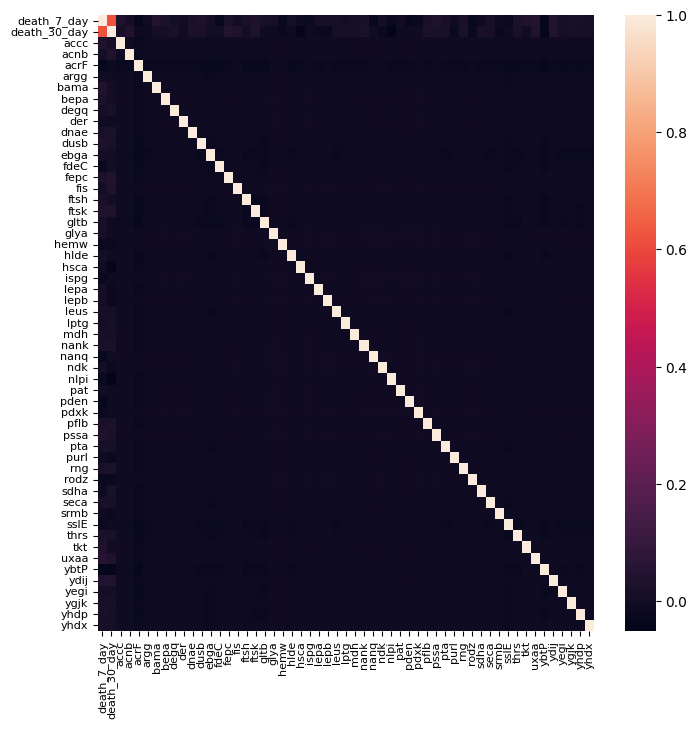

In [47]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm

corrDf = dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr()

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(corrDf)

ticks = np.arange(corrDf.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corrDf.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corrDf.index, rotation=360, fontsize=8)

### Plot correlations as a heatmap (Log scale)

[Text(0, 0.5, 'death_7_day'),
 Text(0, 1.5, 'death_30_day'),
 Text(0, 2.5, 'accc'),
 Text(0, 3.5, 'acnb'),
 Text(0, 4.5, 'acrF'),
 Text(0, 5.5, 'argg'),
 Text(0, 6.5, 'bama'),
 Text(0, 7.5, 'bepa'),
 Text(0, 8.5, 'degq'),
 Text(0, 9.5, 'der'),
 Text(0, 10.5, 'dnae'),
 Text(0, 11.5, 'dusb'),
 Text(0, 12.5, 'ebga'),
 Text(0, 13.5, 'fdeC'),
 Text(0, 14.5, 'fepc'),
 Text(0, 15.5, 'fis'),
 Text(0, 16.5, 'ftsh'),
 Text(0, 17.5, 'ftsk'),
 Text(0, 18.5, 'gltb'),
 Text(0, 19.5, 'glya'),
 Text(0, 20.5, 'hemw'),
 Text(0, 21.5, 'hlde'),
 Text(0, 22.5, 'hsca'),
 Text(0, 23.5, 'ispg'),
 Text(0, 24.5, 'lepa'),
 Text(0, 25.5, 'lepb'),
 Text(0, 26.5, 'leus'),
 Text(0, 27.5, 'lptg'),
 Text(0, 28.5, 'mdh'),
 Text(0, 29.5, 'nank'),
 Text(0, 30.5, 'nanq'),
 Text(0, 31.5, 'ndk'),
 Text(0, 32.5, 'nlpi'),
 Text(0, 33.5, 'pat'),
 Text(0, 34.5, 'pden'),
 Text(0, 35.5, 'pdxk'),
 Text(0, 36.5, 'pflb'),
 Text(0, 37.5, 'pssa'),
 Text(0, 38.5, 'pta'),
 Text(0, 39.5, 'purl'),
 Text(0, 40.5, 'rng'),
 Text(0, 41.5, 'ro

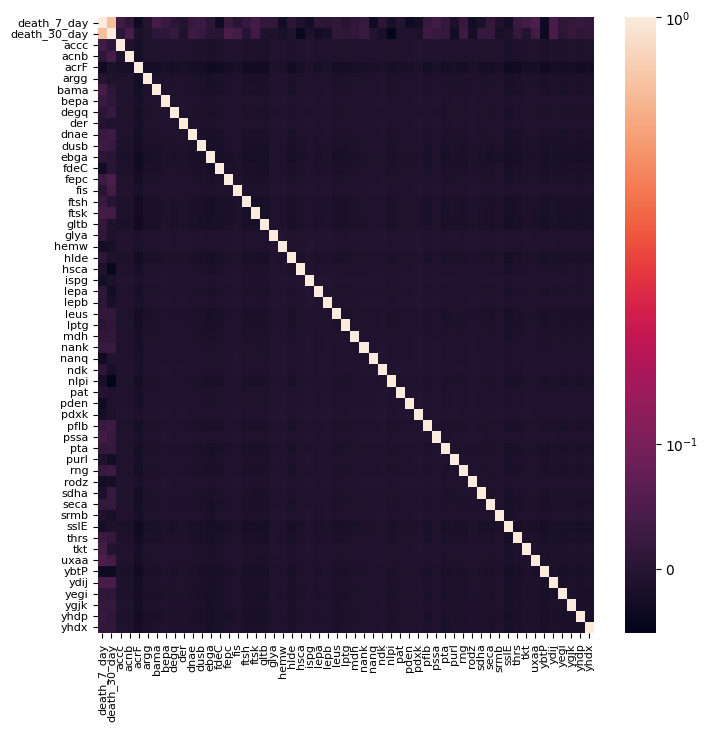

In [48]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm

corrDf = dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr()

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(corrDf, norm=SymLogNorm(linthresh=0.3))

ticks = np.arange(corrDf.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corrDf.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corrDf.index, rotation=360, fontsize=8)

### Plot correlations as a heatmap (Log scale - Sorted)

[Text(0, 0.5, 'death_7_day'),
 Text(0, 1.5, 'death_30_day'),
 Text(0, 2.5, 'uxaa'),
 Text(0, 3.5, 'ydij'),
 Text(0, 4.5, 'bama'),
 Text(0, 5.5, 'ftsk'),
 Text(0, 6.5, 'tkt'),
 Text(0, 7.5, 'pssa'),
 Text(0, 8.5, 'accc'),
 Text(0, 9.5, 'dusb'),
 Text(0, 10.5, 'fepc'),
 Text(0, 11.5, 'thrs'),
 Text(0, 12.5, 'bepa'),
 Text(0, 13.5, 'pflb'),
 Text(0, 14.5, 'rng'),
 Text(0, 15.5, 'dnae'),
 Text(0, 16.5, 'ftsh'),
 Text(0, 17.5, 'yhdp'),
 Text(0, 18.5, 'nank'),
 Text(0, 19.5, 'ygjk'),
 Text(0, 20.5, 'seca'),
 Text(0, 21.5, 'pta'),
 Text(0, 22.5, 'gltb'),
 Text(0, 23.5, 'yhdx'),
 Text(0, 24.5, 'leus'),
 Text(0, 25.5, 'mdh'),
 Text(0, 26.5, 'glya'),
 Text(0, 27.5, 'acnb'),
 Text(0, 28.5, 'lepa'),
 Text(0, 29.5, 'yegi'),
 Text(0, 30.5, 'ebga'),
 Text(0, 31.5, 'lepb'),
 Text(0, 32.5, 'ndk'),
 Text(0, 33.5, 'hlde'),
 Text(0, 34.5, 'degq'),
 Text(0, 35.5, 'lptg'),
 Text(0, 36.5, 'fis'),
 Text(0, 37.5, 'argg'),
 Text(0, 38.5, 'pat'),
 Text(0, 39.5, 'der'),
 Text(0, 40.5, 'srmb'),
 Text(0, 41.5, 'hsc

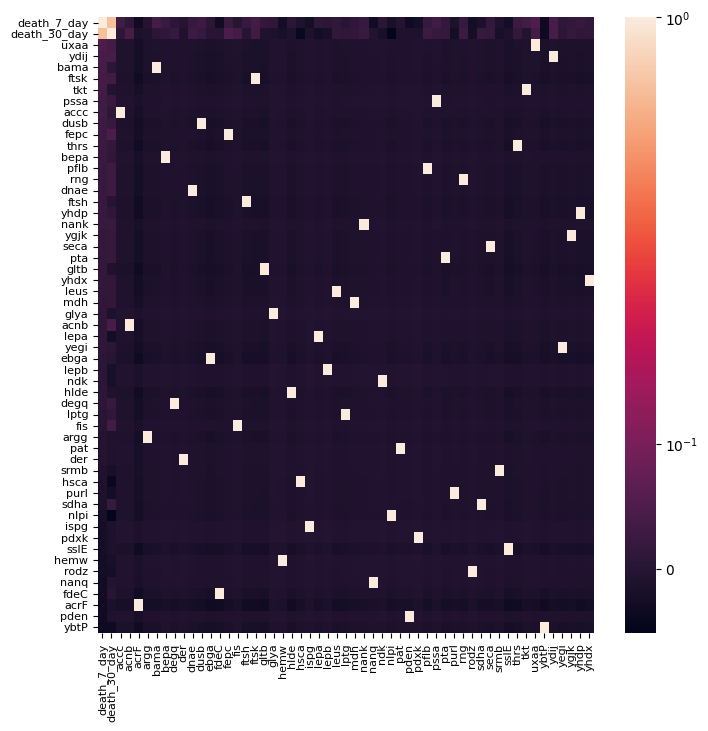

In [49]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm

corrDf = dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_7_day', ascending=False)

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(corrDf, norm=SymLogNorm(linthresh=0.3))

ticks = np.arange(corrDf.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corrDf.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corrDf.index, rotation=360, fontsize=8)

### Plot correlations as a heatmap for 7 day mortality target (Log scale - Sorted)

[Text(0, 0.5, 'death_7_day'),
 Text(0, 1.5, 'uxaa'),
 Text(0, 2.5, 'ydij'),
 Text(0, 3.5, 'bama'),
 Text(0, 4.5, 'ftsk'),
 Text(0, 5.5, 'tkt'),
 Text(0, 6.5, 'pssa'),
 Text(0, 7.5, 'accc'),
 Text(0, 8.5, 'dusb'),
 Text(0, 9.5, 'fepc'),
 Text(0, 10.5, 'thrs'),
 Text(0, 11.5, 'bepa'),
 Text(0, 12.5, 'pflb'),
 Text(0, 13.5, 'rng'),
 Text(0, 14.5, 'dnae'),
 Text(0, 15.5, 'ftsh'),
 Text(0, 16.5, 'yhdp'),
 Text(0, 17.5, 'nank'),
 Text(0, 18.5, 'ygjk'),
 Text(0, 19.5, 'seca'),
 Text(0, 20.5, 'pta'),
 Text(0, 21.5, 'gltb'),
 Text(0, 22.5, 'yhdx'),
 Text(0, 23.5, 'leus'),
 Text(0, 24.5, 'mdh'),
 Text(0, 25.5, 'glya'),
 Text(0, 26.5, 'acnb'),
 Text(0, 27.5, 'lepa'),
 Text(0, 28.5, 'yegi'),
 Text(0, 29.5, 'ebga'),
 Text(0, 30.5, 'lepb'),
 Text(0, 31.5, 'ndk'),
 Text(0, 32.5, 'hlde'),
 Text(0, 33.5, 'degq'),
 Text(0, 34.5, 'lptg'),
 Text(0, 35.5, 'fis'),
 Text(0, 36.5, 'argg'),
 Text(0, 37.5, 'pat'),
 Text(0, 38.5, 'der'),
 Text(0, 39.5, 'srmb'),
 Text(0, 40.5, 'hsca'),
 Text(0, 41.5, 'purl'),
 Te

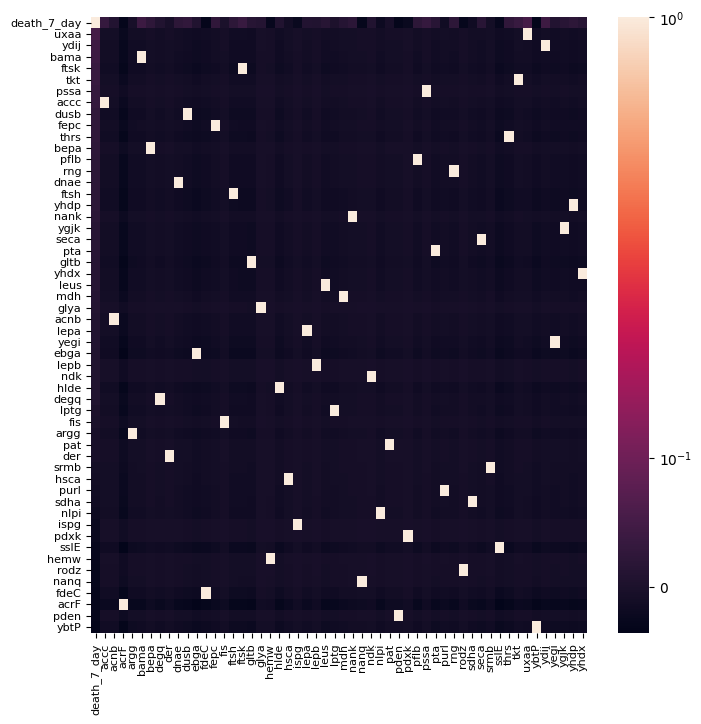

In [50]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm

corrDf = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day']).corr().sort_values('death_7_day', ascending=False)

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(corrDf, norm=SymLogNorm(linthresh=0.3))

ticks = np.arange(corrDf.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corrDf.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corrDf.index, rotation=360, fontsize=8)

### Plot correlations as a heatmap for 30 day mortality target (Log scale - Sorted)

[Text(0, 0.5, 'death_30_day'),
 Text(0, 1.5, 'fepc'),
 Text(0, 2.5, 'acnb'),
 Text(0, 3.5, 'ydij'),
 Text(0, 4.5, 'fis'),
 Text(0, 5.5, 'uxaa'),
 Text(0, 6.5, 'ftsk'),
 Text(0, 7.5, 'pflb'),
 Text(0, 8.5, 'rng'),
 Text(0, 9.5, 'dnae'),
 Text(0, 10.5, 'nank'),
 Text(0, 11.5, 'pssa'),
 Text(0, 12.5, 'degq'),
 Text(0, 13.5, 'sdha'),
 Text(0, 14.5, 'dusb'),
 Text(0, 15.5, 'ygjk'),
 Text(0, 16.5, 'seca'),
 Text(0, 17.5, 'pta'),
 Text(0, 18.5, 'thrs'),
 Text(0, 19.5, 'leus'),
 Text(0, 20.5, 'yhdx'),
 Text(0, 21.5, 'mdh'),
 Text(0, 22.5, 'yhdp'),
 Text(0, 23.5, 'lptg'),
 Text(0, 24.5, 'bepa'),
 Text(0, 25.5, 'accc'),
 Text(0, 26.5, 'bama'),
 Text(0, 27.5, 'yegi'),
 Text(0, 28.5, 'fdeC'),
 Text(0, 29.5, 'ebga'),
 Text(0, 30.5, 'ftsh'),
 Text(0, 31.5, 'tkt'),
 Text(0, 32.5, 'nanq'),
 Text(0, 33.5, 'gltb'),
 Text(0, 34.5, 'der'),
 Text(0, 35.5, 'pden'),
 Text(0, 36.5, 'pat'),
 Text(0, 37.5, 'hlde'),
 Text(0, 38.5, 'argg'),
 Text(0, 39.5, 'sslE'),
 Text(0, 40.5, 'ispg'),
 Text(0, 41.5, 'pdxk'),
 

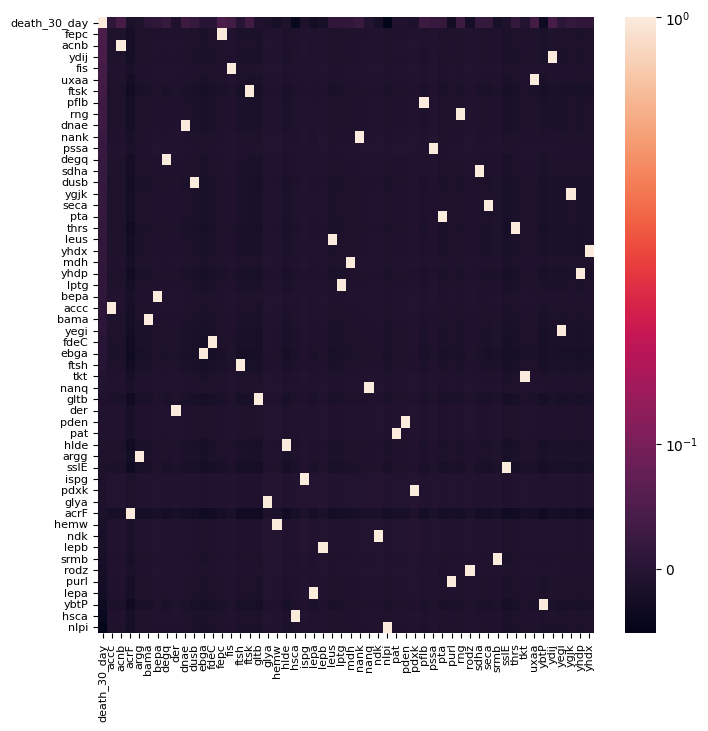

In [51]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm

corrDf = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_7_day']).corr().sort_values('death_30_day', ascending=False)

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(corrDf, norm=SymLogNorm(linthresh=0.3))

ticks = np.arange(corrDf.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corrDf.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corrDf.index, rotation=360, fontsize=8)

### Model using machine learning (7 day mortality)

In [52]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_7_day', 'death_30_day'])
y = dataDf.death_7_day

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.14393939393939395
Balanced Accuracy:  0.4738077769625825
Average Precision:  0.10497947904470546
F1 Score:  0.18705035971223022
ROC AUC:  0.4738077769625825


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.8901515151515151
Balanced Accuracy:  0.5
Average Precision:  0.10984848484848485
F1 Score:  0.0
ROC AUC:  0.5


In [55]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
11,fdeC,-0.855574
43,sslE,-0.587447
32,pden,-0.580871
39,rodz,-0.536291
28,nanq,-0.536291
47,ybtP,-0.479191
18,hemw,-0.436676
33,pdxk,-0.436676
21,ispg,-0.380550
23,lepb,-0.319275


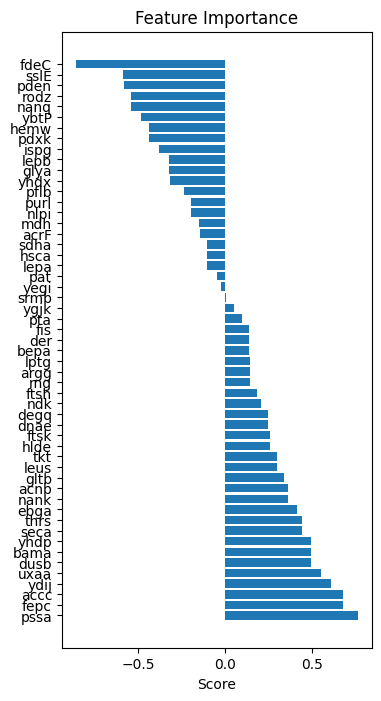

In [56]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(4, 8))

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()


### Model using machine learning (30 day mortality)

In [57]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_7_day', 'death_30_day'])
y = dataDf.death_30_day

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.3181818181818182
Balanced Accuracy:  0.4835978835978836
Average Precision:  0.27759509993552545
F1 Score:  0.41935483870967744
ROC AUC:  0.48359788359788364


In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.7159090909090909
Balanced Accuracy:  0.5
Average Precision:  0.2840909090909091
F1 Score:  0.0
ROC AUC:  0.5


In [60]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
47,ybtP,-0.738517
30,nlpi,-0.722597
20,hsca,-0.609265
22,lepa,-0.609265
23,lepb,-0.584609
17,glya,-0.584609
39,rodz,-0.398564
43,sslE,-0.392186
8,dnae,-0.352534
37,purl,-0.352534


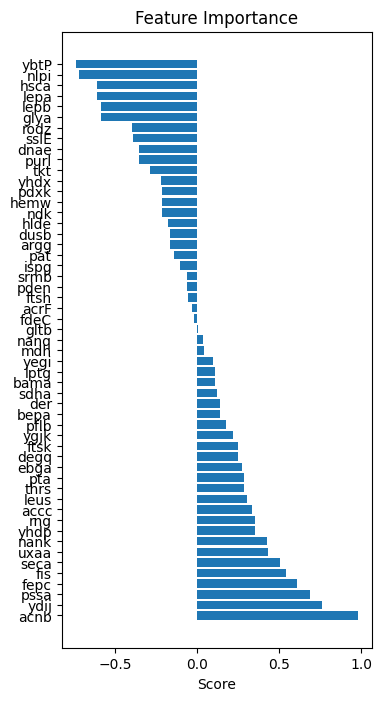

In [61]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(4, 8))

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()


## Create tokens data matrix

In [62]:
import numpy as np


tokenWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['tokens']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
tokenWeightedsumDf

/tmp/ipykernel_112799/457035517.py:4: FutureWarning: The provided callable <function sum at 0x75c855b803a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tokenWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['tokens']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,tokens,weighted_sum
0,A,0.747065
1,AAAAA,343.589110
2,AAAAAAAGA,3.479187
3,AAAAAACA,4.763600
4,AAAAAACTG,5.543830
...,...,...
10426,TTTTTTAT,98.575061
10427,TTTTTTC,3.628669
10428,TTTTTTCAT,15.548193
10429,TTTTTTCATCA,0.450365


In [63]:
signatureTokensDf = highscoreTokenOverlapsDf[highscoreTokenOverlapsDf['tokens'].isin(tokenWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]['tokens'])]
signatureTokensDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
14,1,3277,3282,GAAAAA,0.117982,taub,taurine ABC transporter ATP-binding subunit,AH19C036
15,1,3277,3282,GAAAAA,0.117982,taub,taurine ABC transporter ATP-binding subunit,AH19C036
16,1,3277,3282,GAAAAA,0.117982,taub,taurine ABC transporter ATP-binding subunit,AH19C036
17,1,3277,3282,GAAAAA,0.117982,taub,taurine ABC transporter ATP-binding subunit,AH19C036
18,1,3277,3282,GAAAAA,0.117982,taub,taurine ABC transporter ATP-binding subunit,AH19C036
...,...,...,...,...,...,...,...,...
1072867,1,43292,43297,GGTTTT,0.137939,sslE,lipoprotein metalloprotease SslE,AH20F011
1072870,3,362997,363001,ACCGA,0.107262,acrF,multidrug efflux RND transporter permease subunit AcrF,AH21E004
1072871,3,362997,363001,ACCGA,0.107262,acrF,multidrug efflux RND transporter permease subunit AcrF,AH21E004
1072884,5,35085,35090,GGTTTT,0.144816,sslE,lipoprotein metalloprotease SslE,AH19C036


In [64]:
signatureDataDf = signatureTokensDf[['tube_code', 'tokens']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['tokens'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('tokens',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf


,tube_code,ACCGA,ACGCT,ACGCTG,CACGAT,CATAAA,CATCACC,CCGAC,CGCCGCC,CGGTT,...,CTGGCG,CTGTTC,GAAAAA,GAAGAAG,GAGTT,GATGAA,GATGCG,GCTAAC,GGTTTT,TTAAGC
14,AH19C036,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
28,AH19C036,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
61,AH19C036,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
157,AH19C036,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173,AH19C036,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072544,AH21L124,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1072675,AH21G042,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1072684,AH21G042,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1072685,AH21G042,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create datamatrix

In [65]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='left'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.fillna(0)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_7_day,death_30_day,ACCGA,ACGCT,ACGCTG,CACGAT,CATAAA,CATCACC,...,CTGGCG,CTGTTC,GAAAAA,GAAGAAG,GAGTT,GATGAA,GATGCG,GCTAAC,GGTTTT,TTAAGC
0,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2145022,601149,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2145022,601149,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2214348,600939,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,307218,601850,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,1058066,16759482,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1348,2450777,16762608,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1349,869203,16808421,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1350,2202513,16816295,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate correlation

In [66]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_7_day,death_30_day,ACCGA,ACGCT,ACGCTG,CACGAT,CATAAA,CATCACC,CCGAC,CGCCGCC,...,CTGGCG,CTGTTC,GAAAAA,GAAGAAG,GAGTT,GATGAA,GATGCG,GCTAAC,GGTTTT,TTAAGC
death_30_day,0.607564,1.000000,-0.004633,0.013978,-0.003070,0.008223,0.005528,0.008223,0.023838,0.013978,...,0.004857,0.001859,0.002898,0.007417,0.007417,0.014348,0.014348,-0.011595,-0.007271,0.004857
death_7_day,1.000000,0.607564,0.012044,-0.004057,-0.004057,0.020748,0.018918,0.020748,0.012044,-0.004057,...,0.012044,0.004288,0.017135,0.013700,0.013700,0.012044,0.012044,-0.004057,-0.001376,0.012044
CCGAC,0.012044,0.023838,-0.033639,-0.037769,-0.037769,-0.031610,-0.032025,-0.031610,1.000000,-0.037769,...,-0.033639,-0.035567,-0.032435,-0.033242,-0.033242,-0.033639,-0.033639,-0.037769,-0.037047,-0.033639
CGGTT,0.013700,0.017014,-0.033242,-0.037323,-0.037323,-0.031237,-0.031647,-0.031237,-0.033242,-0.037323,...,-0.033242,-0.035147,-0.032052,-0.032850,-0.032850,-0.033242,-0.033242,-0.037323,-0.036610,-0.033242
GATGCG,0.012044,0.014348,-0.033639,-0.037769,-0.037769,-0.031610,-0.032025,-0.031610,-0.033639,-0.037769,...,-0.033639,-0.035567,-0.032435,-0.033242,-0.033242,-0.033639,1.000000,-0.037769,-0.037047,-0.033639
GATGAA,0.012044,0.014348,-0.033639,-0.037769,-0.037769,-0.031610,-0.032025,-0.031610,-0.033639,-0.037769,...,-0.033639,-0.035567,-0.032435,-0.033242,-0.033242,1.000000,-0.033639,-0.037769,-0.037047,-0.033639
CGCCGCC,-0.004057,0.013978,-0.037769,-0.042406,-0.042406,-0.035490,-0.035956,-0.035490,-0.037769,1.000000,...,-0.037769,-0.039933,-0.036417,-0.037323,-0.037323,-0.037769,-0.037769,-0.042406,-0.041595,-0.037769
ACGCT,-0.004057,0.013978,-0.037769,1.000000,-0.042406,-0.035490,-0.035956,-0.035490,-0.037769,-0.042406,...,-0.037769,-0.039933,-0.036417,-0.037323,-0.037323,-0.037769,-0.037769,-0.042406,-0.041595,-0.037769
CATCACC,0.020748,0.008223,-0.031610,-0.035490,-0.035490,-0.029703,-0.030093,1.000000,-0.031610,-0.035490,...,-0.031610,-0.033421,-0.030478,-0.031237,-0.031237,-0.031610,-0.031610,-0.035490,-0.034812,-0.031610
CACGAT,0.020748,0.008223,-0.031610,-0.035490,-0.035490,1.000000,-0.030093,-0.029703,-0.031610,-0.035490,...,-0.031610,-0.033421,-0.030478,-0.031237,-0.031237,-0.031610,-0.031610,-0.035490,-0.034812,-0.031610


### Plot correlations as a heatmap

<Axes: >

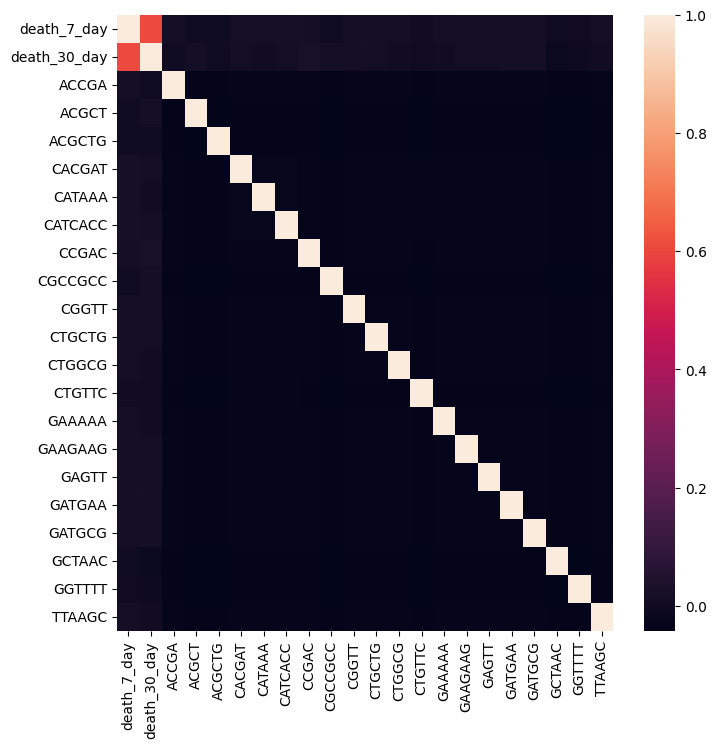

In [67]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr())

### Plot correlations as a heatmap (Log scale)

<Axes: >

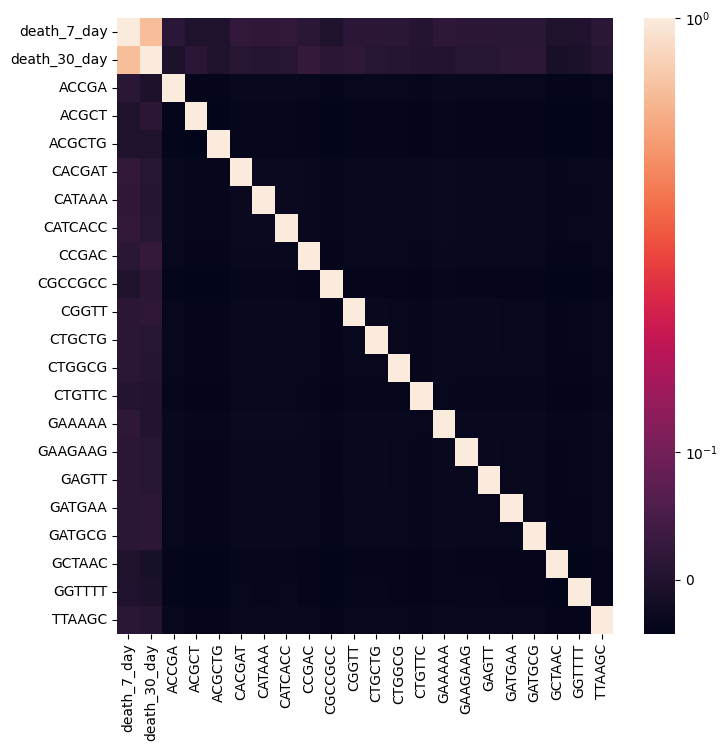

In [68]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr(), norm=SymLogNorm(linthresh=0.3))

### Plot correlations as a heatmap (Log scale - Sorted)

<Axes: >

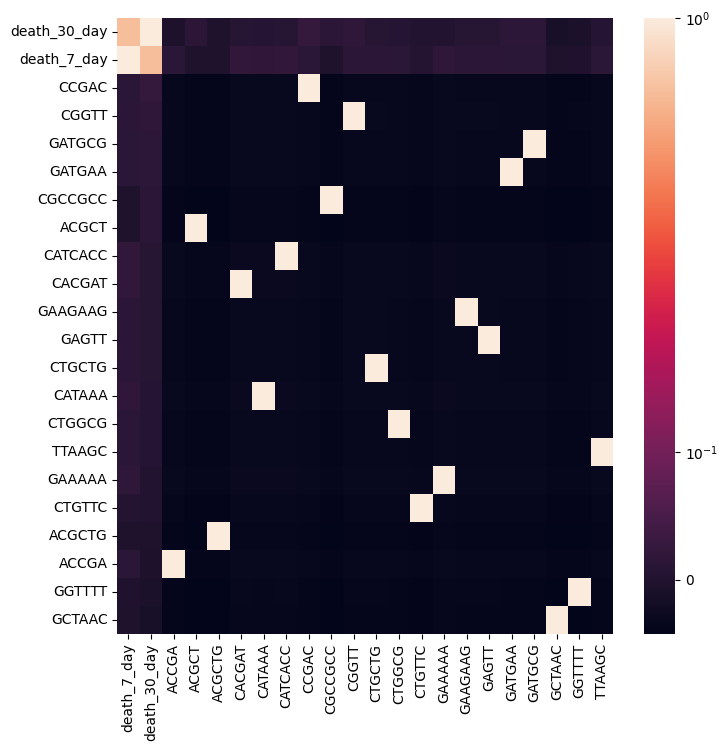

In [69]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False), norm=SymLogNorm(linthresh=0.3))

### Model using machine learning (7 day)

In [70]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day', 'death_7_day'])
y = dataDf.death_7_day

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.6568265682656826
Balanced Accuracy:  0.48603042876901803
Average Precision:  0.10818503121740079
F1 Score:  0.14678899082568808
ROC AUC:  0.4860304287690179


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.8892988929889298
Balanced Accuracy:  0.5
Average Precision:  0.11070110701107011
F1 Score:  0.0
ROC AUC:  0.5


In [73]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
7,CGCCGCC,-0.248498
18,GGTTTT,-0.109424
2,ACGCTG,-0.050579
8,CGGTT,0.058497
14,GAGTT,0.082258
1,ACGCT,0.171427
12,GAAAAA,0.185218
0,ACCGA,0.217188
17,GCTAAC,0.240128
11,CTGTTC,0.261144


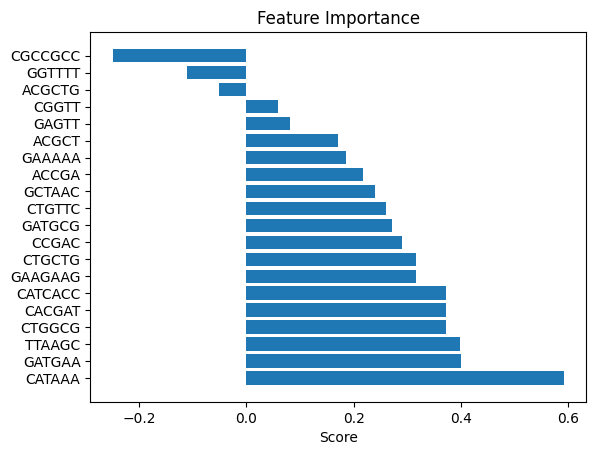

In [74]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()

### Get genes corresponding to the top tokens

In [76]:
highscoreTokenOverlapsDf[highscoreTokenOverlapsDf.tokens == 'CGCCGCC'][['gene']].value_counts()[:20]

gene
srmb    991
yran    381
aega    361
bepa    302
pbpg    298
gals    271
sbma    260
ampg    214
djla    209
fepg    208
seca    205
punc    202
sixa    201
fadj    188
cdd     187
fold    186
chbf    176
ebga    164
ybtQ    159
ents    158
Name: count, dtype: int64

### Model using machine learning (30 day)

In [77]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day', 'death_7_day'])
y = dataDf.death_30_day

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.5571955719557196
Balanced Accuracy:  0.4428231292517007
Average Precision:  0.2608913376805001
F1 Score:  0.1891891891891892
ROC AUC:  0.44282312925170075


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.7232472324723247
Balanced Accuracy:  0.5
Average Precision:  0.2767527675276753
F1 Score:  0.0
ROC AUC:  0.5


In [80]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
18,GGTTTT,-0.071173
9,CTGCTG,-0.052907
0,ACCGA,-0.035798
17,GCTAAC,0.012638
1,ACGCT,0.031142
14,GAGTT,0.055410
19,TTAAGC,0.088473
8,CGGTT,0.150730
3,CACGAT,0.159302
5,CATCACC,0.159302


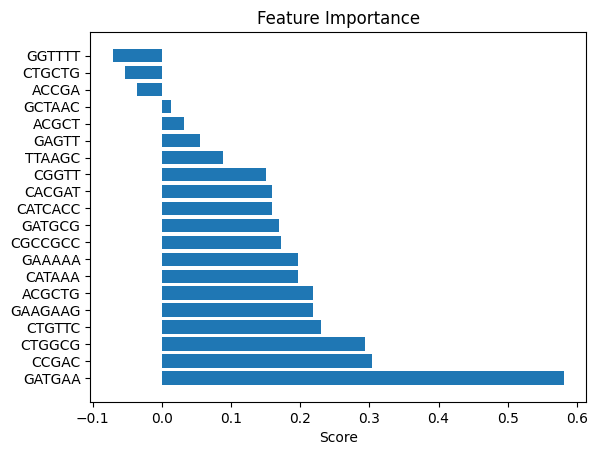

In [81]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()

### Get genes corresponding to the top tokens

In [85]:
highscoreTokenOverlapsDf[highscoreTokenOverlapsDf.tokens == 'GATGAA'][['gene']].value_counts()[:20]

gene
ftsh    717
rnc     714
bcp     280
yegi    251
tuf     202
ypfg    194
hcxa    176
htpg    175
guab    153
thii    152
entc    148
dpib    145
rna     134
thrs    114
crcb    111
aas     104
bamc     95
hemh     89
acnb     89
murd     87
Name: count, dtype: int64